In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom
import skimage

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [88]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4111,00020248_006.png,No Finding,6,20248,026Y,F,AP,3056,2520,0.139,0.139
2009,00010478_011.png,Effusion|Mass,11,10478,055Y,F,AP,2500,2048,0.168,0.168
2990,00014711_000.png,No Finding,0,14711,057Y,F,PA,2048,2500,0.168,0.168


In [89]:
# split finding labels into columns
all_findings = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
for label in all_findings:
    df[label] = df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
41550,00010737_019.png,No Finding,19,10737,9,M,PA,1910,1989,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
104265,00027851_001.png,No Finding,1,27851,41,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
56149,00014004_030.png,No Finding,30,14004,58,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Patient Gender
F    48780
M    63340
Name: Patient ID, dtype: int64

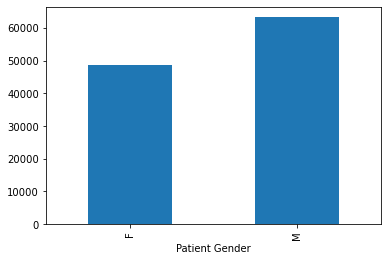

In [90]:
# Gender
gender_count = df.groupby(['Patient Gender'])['Patient ID'].count()
gender_count.plot(kind='bar')
gender_count

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

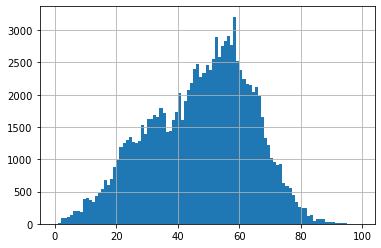

In [91]:
# Age
df['Patient Age'].hist(bins=np.arange(0,100,1))
df['Patient Age'].describe()

View Position
AP    44810
PA    67310
Name: Patient ID, dtype: int64

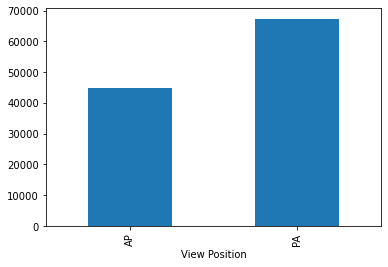

In [92]:
# View Patient Position
vp_count = df.groupby(['View Position'])['Patient ID'].count()
vp_count.plot(kind='bar')
vp_count

In [93]:
# number of findings
print('Number of finding labels in the dataset:', len(all_findings))
all_findings

Number of finding labels in the dataset: 15


array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'], dtype='<U18')

[Text(0, 0.5, 'Frequency')]

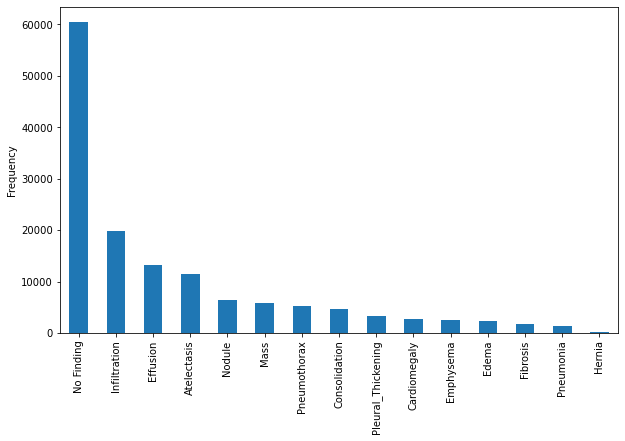

In [94]:
# Labels frequency Histogram
plt.figure(figsize=(10,6))
labels_hist = df[all_labels].sum().sort_values(ascending=False).plot(kind='bar')
labels_hist.set(ylabel = 'Frequency')

## Pneumonia EDA

In [95]:
# Pneumonia cases
positive_pneumonia = df[df.Pneumonia==1]['Patient ID'].value_counts().sum()
negative_pneumonia = df[df.Pneumonia==0]['Patient ID'].value_counts().sum()

print("Pneumonia cases: {}/{}".format(positive_pneumonia, negative_pneumonia))

Pneumonia cases: 1431/110689


M    838
F    593
Name: Patient Gender, dtype: int64

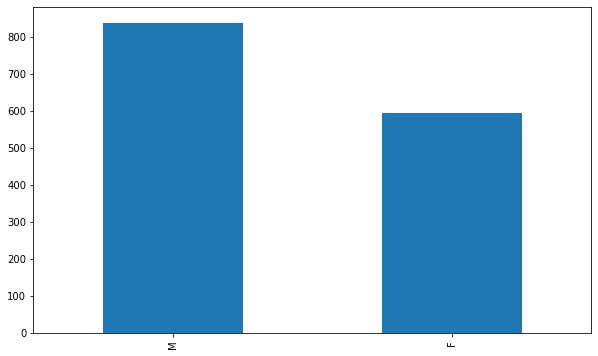

In [96]:
# Frequency of Pneumonia cases based on gender
pneumonia_gender = df[df.Pneumonia==1]['Patient Gender'].value_counts()
plt.figure(figsize=(10,6))
pneumonia_gender.plot(kind='bar')
pneumonia_gender

[Text(0.5, 1.0, 'Age distribution for patients with Pneumonia')]

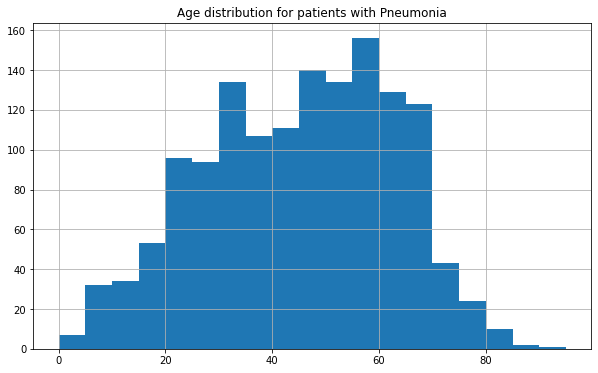

In [97]:
# Info about Pneumonia cases based on age
df.groupby(['Pneumonia'])['Patient Age'].describe()
plt.figure(figsize=(10,6))
dist = df[df.Pneumonia==1]['Patient Age'].hist(bins=np.arange(0,100,5))
dist.set(title = 'Age distribution for patients with Pneumonia')


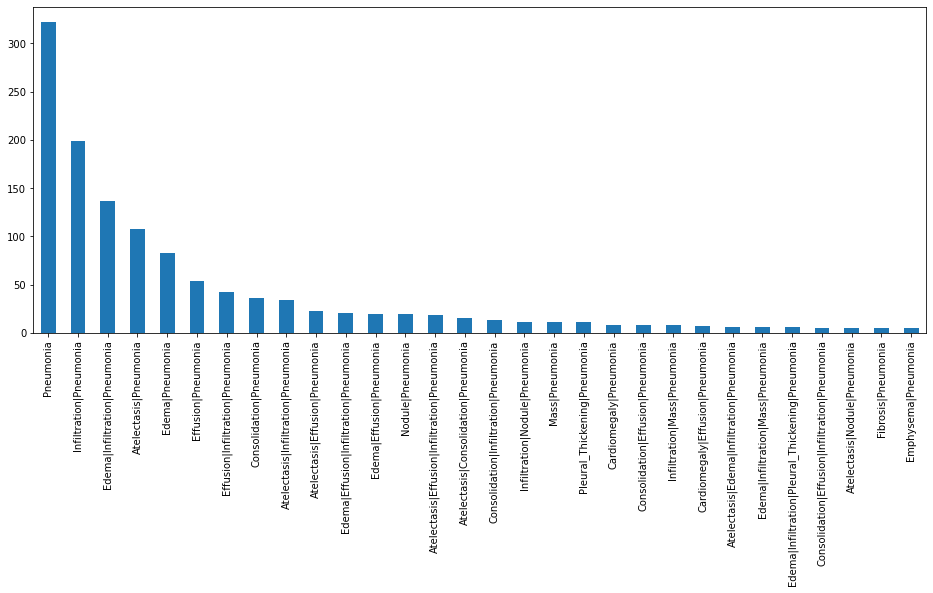

In [98]:
# Distribution of the top 30 diseases that are comorbid with pneumonia
plt.figure(figsize=(16,6))
df[df.Pneumonia==1]['Finding Labels'].value_counts()[:30].plot(kind='bar')

In [99]:
# Reading all DICOMs files
mydicoms = glob("*.dcm")
mydicoms

['test5.dcm', 'test2.dcm', 'test6.dcm', 'test4.dcm', 'test3.dcm', 'test1.dcm']

In [100]:
# Create df from all files
all_data = []

for i in mydicoms: 
    dcm = pydicom.dcmread(i)
    fields = [dcm.PatientID, int(dcm.PatientAge), dcm.PatientSex, dcm.Modality, dcm.StudyDescription,
             dcm.Rows, dcm.Columns]
    all_data.append(fields)

In [101]:
mydata = pd.DataFrame(all_data, 
                      columns = ['PatientID','PatientAge','PatientSex','Modality','Findings','Rows','Columns'])

In [102]:
mydata

,PatientID,PatientAge,PatientSex,Modality,Findings,Rows,Columns
0,2,81,M,CT,No Finding,1024,1024
1,1,58,M,DX,Cardiomegaly,1024,1024
2,2,81,M,DX,No Finding,1024,1024
3,2,81,M,DX,No Finding,1024,1024
4,61,77,M,DX,Effusion,1024,1024
5,2,81,M,DX,No Finding,1024,1024


In [111]:
def plot_imgs(df):
    for i, row in df.head(5).iterrows():
        path = os.path.join("/data/images_001/images/", row['Image Index'])
        if not os.path.exists(path): continue
        image_file = plt.imread(path)
        plt.imshow(image_file, cmap='gray')
        plt.show()

        plt.hist(image_file.ravel(), bins=256)
        plt.show()

In [104]:
no_findings = df[df['Finding Labels']=="No Finding"]
pneumonia = df[df.Pneumonia==1]
pneumonia_infiltration = df[df['Finding Labels']=="Infiltration|Pneumonia"]
pneumonia_infiltration_edema = df[df['Finding Labels']=="Edema|Infiltration|Pneumonia"]

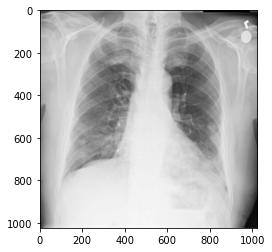

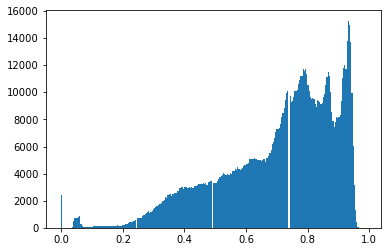

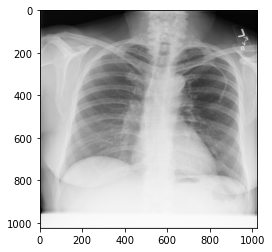

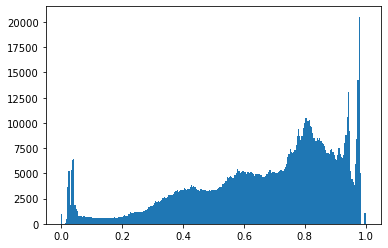

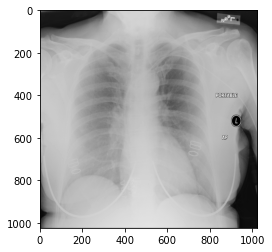

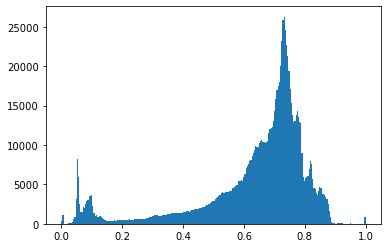

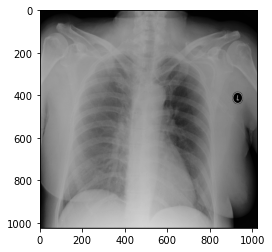

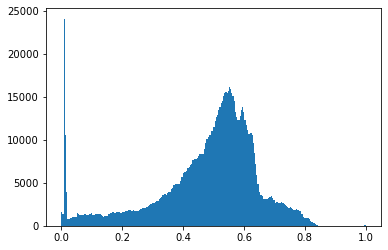

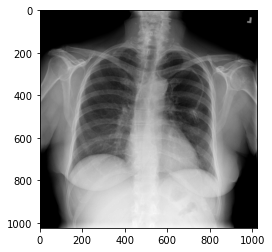

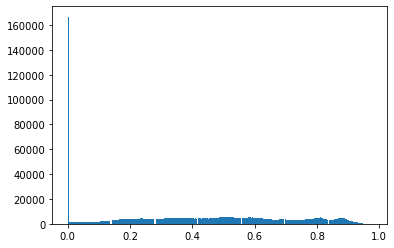

In [105]:
# plot images with no findings
plot_imgs(no_findings)

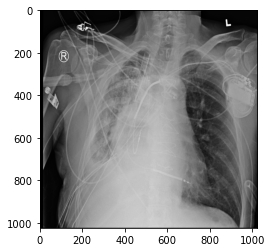

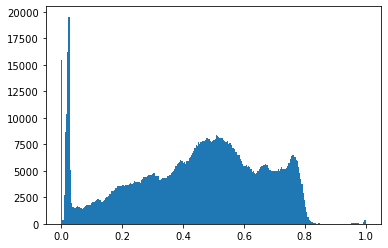

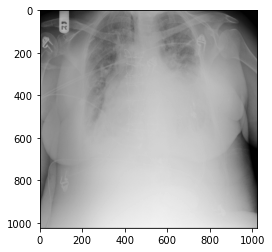

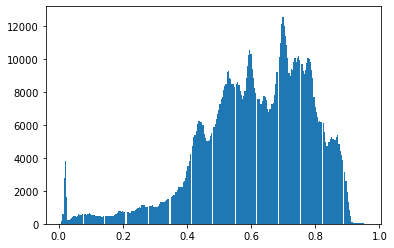

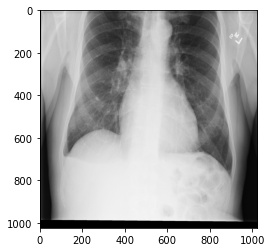

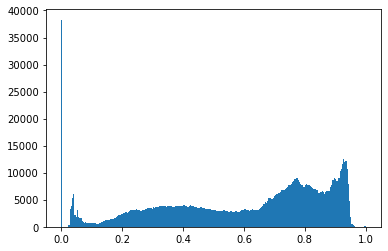

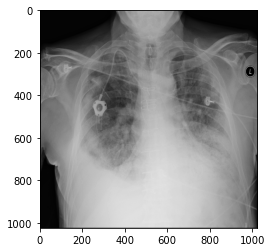

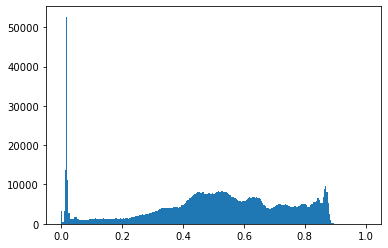

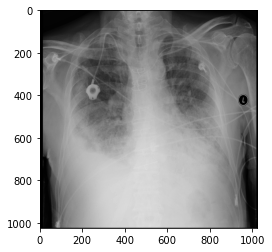

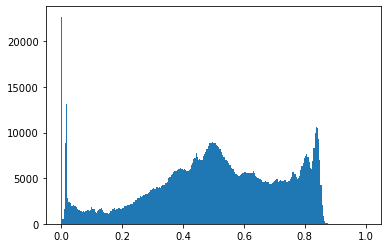

In [106]:
# plot images with Pneumonia
plot_imgs(pneumonia)

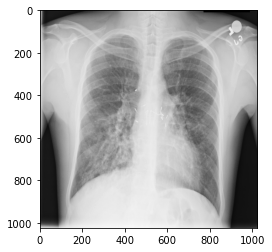

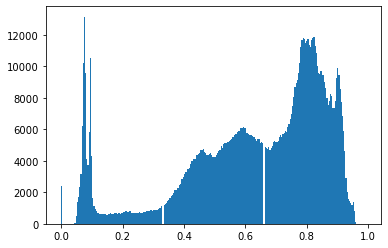

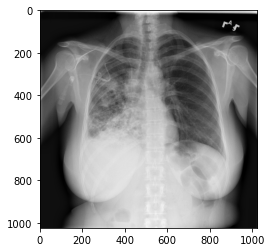

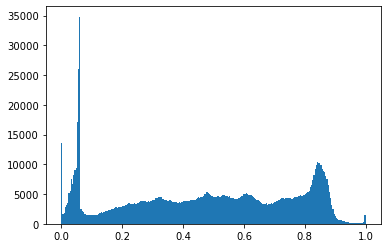

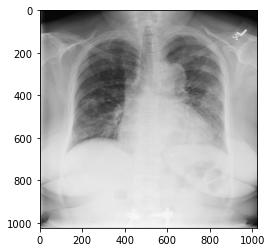

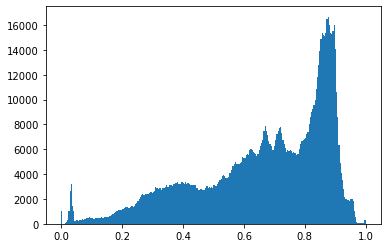

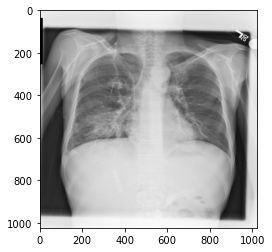

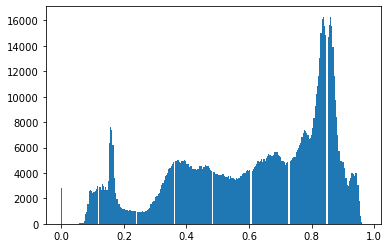

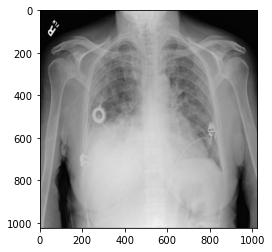

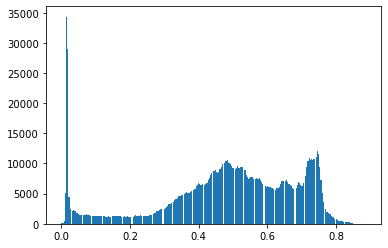

In [107]:
# plot images with Pneumonia and Infiltration
plot_imgs(pneumonia_infiltration)

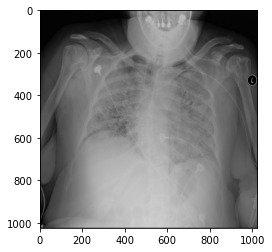

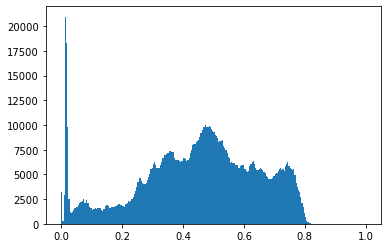

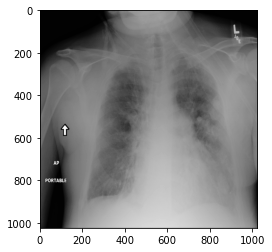

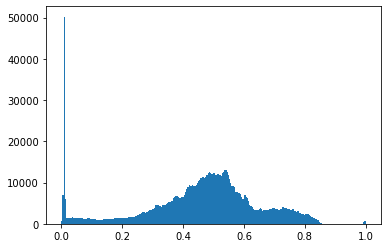

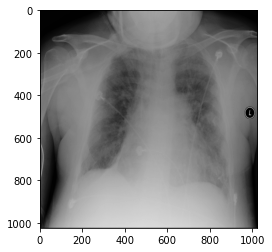

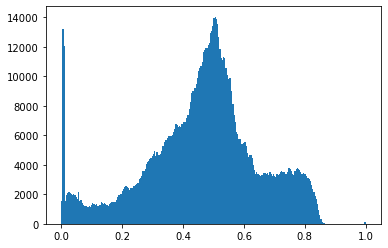

In [112]:
# plot images with Pneumonia, Infiltration nad Edema
plot_imgs(pneumonia_infiltration_edema)

## Discussions
From the figures above, it looks like:
* The images with no findings show a tendency toward bright intensity.
* Image intensities with Pneumonia peak at around the middle.
* Noise needs to be removed.
* Data augmentation is required since the dataset contains few pationts with Pneumonia compared to its size.